In [1]:
import pandas as pd
data = pd.read_csv("/kaggle/input/thesis/loan.csv")
data.head()

/tmp/ipykernel_24/261206482.py:2: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/kaggle/input/thesis/loan.csv")


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
!pip install -U tensorflow
!pip install -U scikeras
!pip install --upgrade scikit-learn
!pip install --upgrade eli5


INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement ml-dtypes~=0.3.1 (from tensorflow) (from versions: none)
ERROR: No matching distribution found for ml-dtypes~=0.3.1
ERROR: Could not find a version that satisfies the requirement scikeras (from versions: none)
ERROR: No matching distribution found for scikeras


In [3]:
del_columns = []
for col in data.columns:
    if (data[col].isnull().sum() / len(data) * 100) > 90:
        del_columns.append(col)

data = data.drop(columns=del_columns)

In [4]:
id_columns = ["id", "member_id"]
data = data.drop(columns=id_columns)

feat_arr = ["addr_state", "zip_code"]
print(data[feat_arr].describe())
for col in feat_arr:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

data["2_digit_zip"] = data["zip_code"].apply(lambda x: int(x[:2]))
data = data.drop(columns=["addr_state", "zip_code"])

feat_arr_num = ["annual_inc"]
feat_arr_cat = ["verification_status", "emp_length", "emp_title"]
print(data[feat_arr_num].describe())
print(data[feat_arr_cat].describe())
for col in feat_arr_num+feat_arr_cat:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

       addr_state zip_code
count      887379   887379
unique         51      935
top            CA    945xx
freq       129517     9770
missing % addr_state: 0.0
missing % zip_code: 0.0
         annual_inc
count  8.873750e+05
mean   7.502759e+04
std    6.469830e+04
min    0.000000e+00
25%    4.500000e+04
50%    6.500000e+04
75%    9.000000e+04
max    9.500000e+06
       verification_status emp_length emp_title
count               887379     842554    835917
unique                   3         11    299271
top        Source Verified  10+ years   Teacher
freq                329558     291569     13469
missing % annual_inc: 0.00045076568185634325
missing % verification_status: 0.0
missing % emp_length: 5.051392922302647
missing % emp_title: 5.799325879922783


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [6]:
def clean_emp_length(x):
    if pd.isna(x):
        return None
    elif isinstance(x, float):
        return None  # Handle float values by returning None
    elif x.strip().lower() == "< 1 year":
        return 0
    elif x.strip().lower() == "1 year":
        return 1
    elif x.strip().lower() == "10+ years":
        return 11
    else:
        return int(x.rstrip("years").strip())


data["emp_length"] = data["emp_length"].apply(clean_emp_length)
data["emp_length"] = data["emp_length"].fillna(value=data["emp_length"].mean())

data["annual_inc"] = data["annual_inc"].fillna(value=data["annual_inc"].mean())

le = LabelEncoder()
data['verification_status'] = le.fit_transform(data['verification_status'])

data = data.drop(columns=["emp_title"])

In [7]:
feat_arr_cat = ["purpose", "initial_list_status", "issue_d"]
print(data[feat_arr_cat].describe())
for col in feat_arr_cat:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

                   purpose initial_list_status   issue_d
count               887379              887379    887379
unique                  14                   2       103
top     debt_consolidation                   f  Oct-2015
freq                524215              456848     48631
missing % purpose: 0.0
missing % initial_list_status: 0.0
missing % issue_d: 0.0


In [8]:
le = LabelEncoder()
data['purpose'] = le.fit_transform(data['purpose'])
data['initial_list_status'] = le.fit_transform(data['initial_list_status'])

def compute_time_since(x):
    if pd.isna(x): return None
    given_date = datetime.strptime(x, "%b-%Y")
    current_date = datetime.now()
    return (current_date - given_date).days / 365.25

data["issue_d"] = data["issue_d"].apply(compute_time_since)

data = data.drop(columns=["desc", "title", "url", "policy_code", "application_type"])

In [9]:
feat_arr_num = ["loan_amnt", "int_rate", "installment", "funded_amnt", "funded_amnt_inv",
"total_pymnt", "total_pymnt_inv", "last_pymnt_amnt", "total_rec_late_fee"]
data[feat_arr_num].describe()

,loan_amnt,int_rate,installment,funded_amnt,funded_amnt_inv,total_pymnt,total_pymnt_inv,last_pymnt_amnt,total_rec_late_fee
count,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000
mean,14755.264605,13.246740,436.717127,14741.877625,14702.464383,7558.826684,7521.160306,2164.145585,0.396692
std,8435.455601,4.381867,244.186593,8429.897657,8442.106732,7871.243336,7846.108604,4794.783233,4.087825
min,500.000000,5.320000,15.670000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,9.990000,260.705000,8000.000000,8000.000000,1914.590000,1899.700000,280.170000,0.000000
50%,13000.000000,12.990000,382.550000,13000.000000,13000.000000,4894.999117,4862.010000,462.780000,0.000000
75%,20000.000000,16.200000,572.600000,20000.000000,20000.000000,10616.814231,10565.690000,831.245000,0.000000
max,35000.000000,28.990000,1445.460000,35000.000000,35000.000000,57777.579870,57777.580000,36475.590000,358.680000


In [10]:
feat_arr_cat = ["term", "last_pymnt_d"]
data[feat_arr_cat].describe()

,term,last_pymnt_d
count,887379,869720
unique,2,98
top,36 months,Jan-2016
freq,621125,470150


In [11]:
for col in feat_arr_cat+feat_arr_num:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

missing % term: 0.0
missing % last_pymnt_d: 1.9900177939752912
missing % loan_amnt: 0.0
missing % int_rate: 0.0
missing % installment: 0.0
missing % funded_amnt: 0.0
missing % funded_amnt_inv: 0.0
missing % total_pymnt: 0.0
missing % total_pymnt_inv: 0.0
missing % last_pymnt_amnt: 0.0
missing % total_rec_late_fee: 0.0


In [12]:
le = LabelEncoder()
data['term'] = le.fit_transform(data['term'])

data["last_pymnt_d"] = data["last_pymnt_d"].apply(compute_time_since)
data["last_pymnt_d"] = data["last_pymnt_d"].fillna(value=data["last_pymnt_d"].mean())

data = data.drop(columns=["total_rec_int", "total_rec_prncp", "out_prncp", "out_prncp_inv", "pymnt_plan"])

feat_arr_num = ["dti","earliest_cr_line","delinq_2yrs","collections_12_mths_ex_med",
"inq_last_6mths","total_rev_hi_lim","acc_now_delinq","tot_coll_amt","tot_cur_bal",
"last_credit_pull_d","open_acc","total_acc","mths_since_last_delinq",
"mths_since_last_major_derog","mths_since_last_record","pub_rec","revol_bal","revol_util"]
data[feat_arr_num].describe()

,dti,delinq_2yrs,collections_12_mths_ex_med,inq_last_6mths,total_rev_hi_lim,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc,total_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,pub_rec,revol_bal,revol_util
count,887379.000000,887350.000000,887234.000000,887350.000000,8.171030e+05,887350.000000,8.171030e+05,8.171030e+05,887350.000000,887350.000000,433067.000000,221703.000000,137053.000000,887350.000000,8.873790e+05,886877.000000
mean,18.157039,0.314442,0.014380,0.694623,3.206862e+04,0.004991,2.257026e+02,1.394582e+05,11.548469,25.268026,34.063798,44.104838,70.117903,0.195307,1.692079e+04,55.067693
std,17.190626,0.862244,0.134191,0.998448,3.749826e+04,0.077625,1.031137e+04,1.537500e+05,5.317313,11.840561,21.884940,22.179841,28.127914,0.582091,2.242679e+04,23.834344
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,11.910000,0.000000,0.000000,0.000000,1.390000e+04,0.000000,0.000000e+00,2.985300e+04,8.000000,17.000000,15.000000,27.000000,51.000000,0.000000,6.443000e+03,37.700000
50%,17.650000,0.000000,0.000000,0.000000,2.370000e+04,0.000000,0.000000e+00,8.055900e+04,11.000000,24.000000,31.000000,44.000000,70.000000,0.000000,1.187500e+04,56.000000
75%,23.950000,0.000000,0.000000,1.000000,3.980000e+04,0.000000,0.000000e+00,2.082050e+05,14.000000,32.000000,50.000000,61.000000,92.000000,0.000000,2.082900e+04,73.600000
max,9999.000000,39.000000,20.000000,33.000000,9.999999e+06,14.000000,9.152545e+06,8.000078e+06,90.000000,169.000000,188.000000,188.000000,129.000000,86.000000,2.904836e+06,892.300000


In [13]:
feat_arr_cat = ["earliest_cr_line", "last_credit_pull_d"]
data[feat_arr_cat].describe()

,earliest_cr_line,last_credit_pull_d
count,887350,887326
unique,697,103
top,Aug-2001,Jan-2016
freq,6659,730574


In [14]:
for col in feat_arr_cat+feat_arr_num:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

missing % earliest_cr_line: 0.0032680511934584885
missing % last_credit_pull_d: 0.005972645284596547
missing % dti: 0.0
missing % earliest_cr_line: 0.0032680511934584885
missing % delinq_2yrs: 0.0032680511934584885
missing % collections_12_mths_ex_med: 0.016340255967292442
missing % inq_last_6mths: 0.0032680511934584885
missing % total_rev_hi_lim: 7.919502264534094
missing % acc_now_delinq: 0.0032680511934584885
missing % tot_coll_amt: 7.919502264534094
missing % tot_cur_bal: 7.919502264534094
missing % last_credit_pull_d: 0.005972645284596547
missing % open_acc: 0.0032680511934584885
missing % total_acc: 0.0032680511934584885
missing % mths_since_last_delinq: 51.19706461387975
missing % mths_since_last_major_derog: 75.01597400885078
missing % mths_since_last_record: 84.55530275113566
missing % pub_rec: 0.0032680511934584885
missing % revol_bal: 0.0
missing % revol_util: 0.05657109307297107


In [15]:
data["earliest_cr_line"] = data["earliest_cr_line"].apply(compute_time_since)
data["last_credit_pull_d"] = data["last_credit_pull_d"].apply(compute_time_since)

data[feat_arr_num] = data[feat_arr_num].fillna(data[feat_arr_num].mean())
data[feat_arr_cat] = data[feat_arr_cat].fillna(data[feat_arr_cat].mean())

le = LabelEncoder()
data['grade'] = le.fit_transform(data['grade'])
data['sub_grade'] = le.fit_transform(data['sub_grade'])

In [16]:
le = LabelEncoder()
data['home_ownership'] = le.fit_transform(data['home_ownership'])


<Axes: xlabel='count', ylabel='loan_status'>

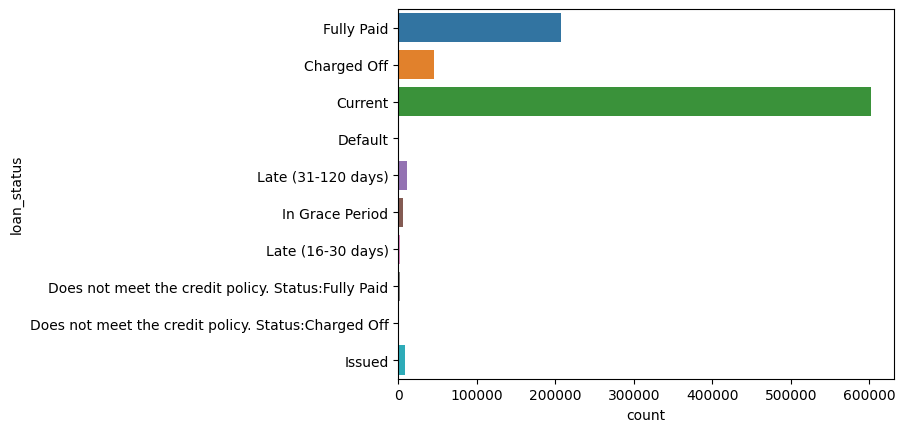

In [17]:
sns.countplot(data=data, y="loan_status")

<Axes: xlabel='count', ylabel='target'>

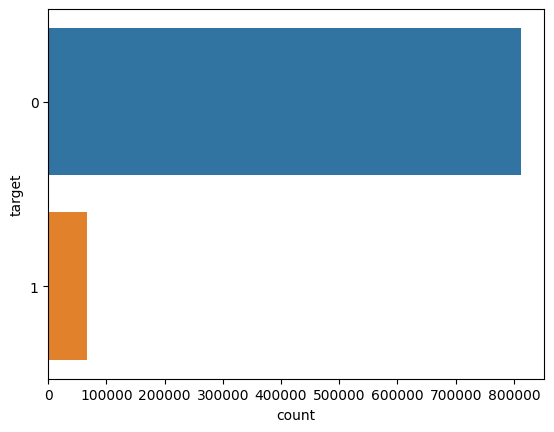

In [18]:
def binarize_target(loan_status):
    cat_0_words = ["paid", "current"]
    cat_1_words = ["charged off", "late", "default", "grace period"]
    for word in cat_0_words:
        if loan_status.lower().find(word)!=-1: return 0
    for word in cat_1_words:
        if loan_status.lower().find(word)!=-1: return 1
    return -1

data["target"] = data["loan_status"].apply(binarize_target)
data = data[data["target"]!=-1]
sns.countplot(data=data, y="target")

In [19]:
X = data.drop(columns=["loan_status", "target"])
y = data[["target"]]

from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Check if 'date_column' exists in X_train
if 'next_pymnt_d' in X.columns:
    # Convert date columns
    X['next_pymnt_d'] = pd.to_datetime(X['next_pymnt_d'])
    X['year'] = X['next_pymnt_d'].dt.year
    X['month'] = X['next_pymnt_d'].dt.month
    X['day'] = X['next_pymnt_d'].dt.day
    X = X.drop(columns=['next_pymnt_d'])
else:
    print("Column 'date_column' not found in X_train.")

# Convert categorical columns using LabelEncoder
label_encoders = {}
non_numeric_columns = X.select_dtypes(exclude=['number']).columns # Get non-numeric columns
for col in non_numeric_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print(X.dtypes)

/tmp/ipykernel_24/616444714.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['next_pymnt_d'] = pd.to_datetime(X['next_pymnt_d'])


loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                             int64
int_rate                       float64
installment                    float64
grade                            int64
sub_grade                        int64
emp_length                     float64
home_ownership                   int64
annual_inc                     float64
verification_status              int64
issue_d                        float64
purpose                          int64
dti                            float64
delinq_2yrs                    float64
earliest_cr_line               float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
initial_list_status      

In [20]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [21]:
kf = KFold(n_splits=20, shuffle=True, random_state=42)

In [22]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  
X_imputed = imputer.fit_transform(X)

X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Light BGM

In [24]:

from sklearn.metrics import accuracy_score, f1_score, precision_score 
import lightgbm as lgb

In [25]:
lgb_best_accuracy = 0 
lgb_best_model = None

fold = 1
for train_index, test_index in kf.split(X_imputed):
    X_train, X_test = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the LightGBM model
    train_data = lgb.Dataset(X_train, label=y_train)
    params = {'objective': 'binary', 'metric': 'binary_logloss'}
    lgb_model = lgb.train(params, train_data)
    
    # Predict and evaluate
    y_pred = lgb_model.predict(X_test)
    y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
    
    accuracy = accuracy_score(y_test, y_pred_binary)
    
    if accuracy > lgb_best_accuracy:
        lgb_best_accuracy = accuracy
        lgb_best_model = lgb_model

    print(f"Fold {fold} - Accuracy: {accuracy:.4f}")
    fold += 1

print(f"\nBest Accuracy: {lgb_best_accuracy:.4f}")



[LightGBM] [Info] Number of positive: 64038, number of negative: 770935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5907
[LightGBM] [Info] Number of data points in the train set: 834973, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076695 -> initscore=-2.488127
[LightGBM] [Info] Start training from score -2.488127
Fold 1 - Accuracy: 0.9868
[LightGBM] [Info] Number of positive: 64073, number of negative: 770900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5907
[LightGBM] [Info] Number of data points in the train set: 834973, number of used f

In [28]:
y_pred_lgb = lgb_best_model.predict(X_test)
y_pred_binary_lgb = [1 if pred >= 0.5 else 0 for pred in y_pred]


accuracy_lgb = accuracy_score(y_test, y_pred_binary_lgb) 
f1_lgb = f1_score(y_test, y_pred_binary_lgb, average='weighted') 
precision_lgb = precision_score(y_test, y_pred_binary_lgb, average='weighted')

print(accuracy_lgb)
print(f1_lgb)
print(precision_lgb)

0.9875753783138014
0.9871295732083146
0.9876180340361534


In [30]:
# = lgbm_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_lgb)
print(f"ROC AUC Score of Light Gradient Boosting Machine: {roc_auc:.4f}")


ROC AUC Score of Light Gradient Boosting Machine: 0.9856


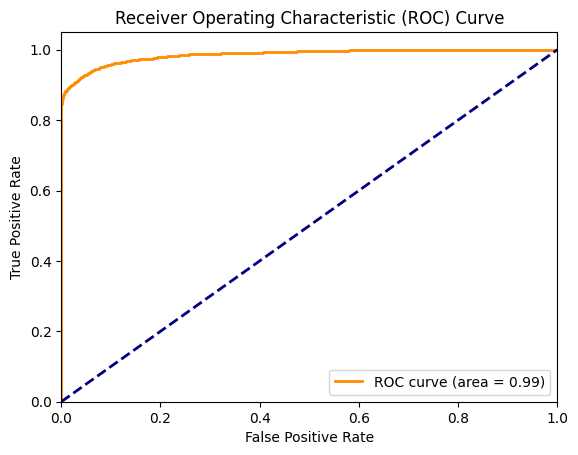

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_pred_lgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Adaptive Boosting

In [32]:
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
base_estimator = DecisionTreeClassifier(max_depth=1)
ada_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)


ada_model.fit(X_train, y_train)



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [35]:
y_pred_best_adb = ada_model.predict(X_test)
adb_accuracy_best = accuracy_score(y_test, y_pred_best_adb)
adb_f1_best = f1_score(y_test, y_pred_best_adb, average='weighted')
adb_precision_best = precision_score(y_test, y_pred_best_adb, average='weighted')
adb_roc_auc = roc_auc_score(y_test, y_pred_best_adb)


print(adb_accuracy_best)
print(adb_f1_best)
print(adb_precision_best)
print(adb_roc_auc)

0.9798332043872024
0.9788968804872192
0.9794140205170727
0.8874586272549242


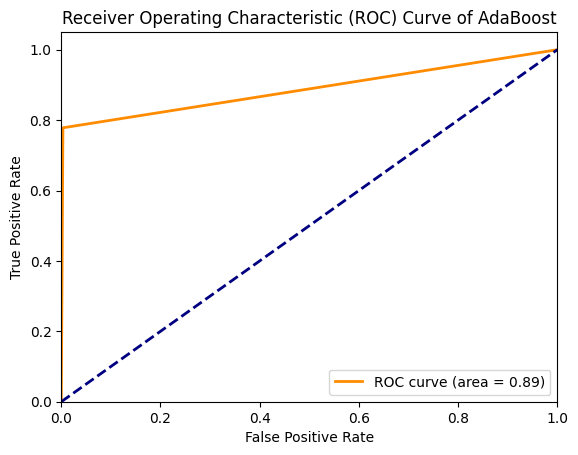

In [37]:
fpr_adb, tpr_adb, _ = roc_curve(y_test, y_pred_best_adb)
roc_auc_adb = auc(fpr_adb, tpr_adb)

plt.figure()
plt.plot(fpr_adb, tpr_adb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_adb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of AdaBoost')
plt.legend(loc="lower right")
plt.show()


# Decision Tree

In [38]:
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [84]:
y_pred_dt = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted')
dt_precision = precision_score(y_test, y_pred_dt, average='weighted')
dt_roc_auc = roc_auc_score(y_test, y_pred_dt)

print(dt_accuracy)
print(dt_f1)
print(dt_precision)
print(dt_roc_auc)

0.982963940593759
0.9830412608293037
0.9831334033163175
0.9448375780391483


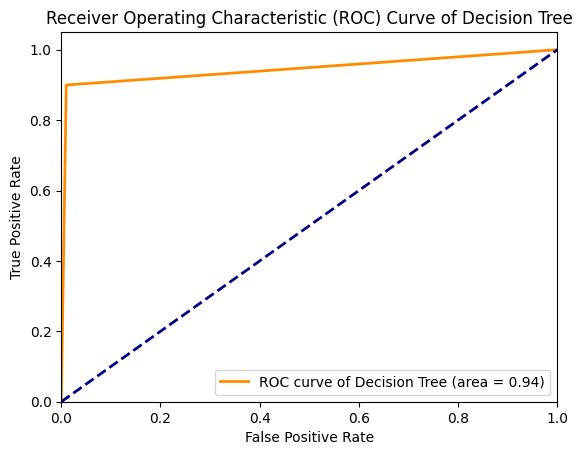

In [85]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve of Decision Tree (area = {dt_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Decision Tree')
plt.legend(loc="lower right")
plt.show()


# Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=131543)

rf = RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    bootstrap=True,
    oob_score=False,
    random_state=131543,
    n_jobs=-1,
    warm_start=False,
    class_weight="balanced"
)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       n_jobs=-1, random_state=131543)

In [89]:
y_pred_rf = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)

print(rf_accuracy)
print(rf_f1)
print(rf_precision)
print(rf_roc_auc)

0.9494038137714468
0.9528303870525368
0.9592543503874674
0.9039101374315294


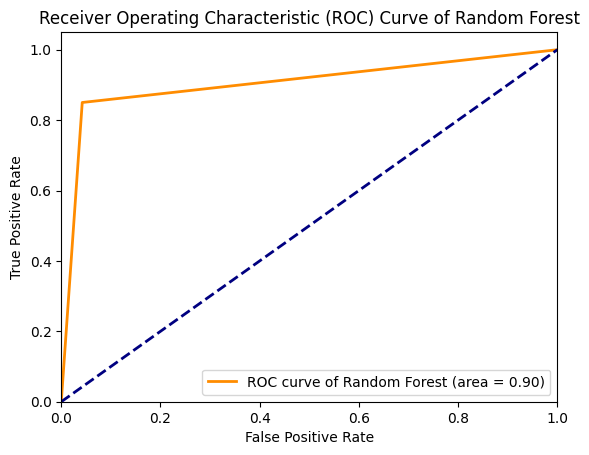

In [90]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve of Random Forest (area = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Random Forest')
plt.legend(loc="lower right")
plt.show()


# Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [50]:
y_pred_lr = model_lr.predict(X_test)

# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
lr_roc_auc = roc_auc_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")

print(lr_roc_auc)


Accuracy: 0.9502
Precision: 0.9519
Recall: 0.9502
0.6806723966071161


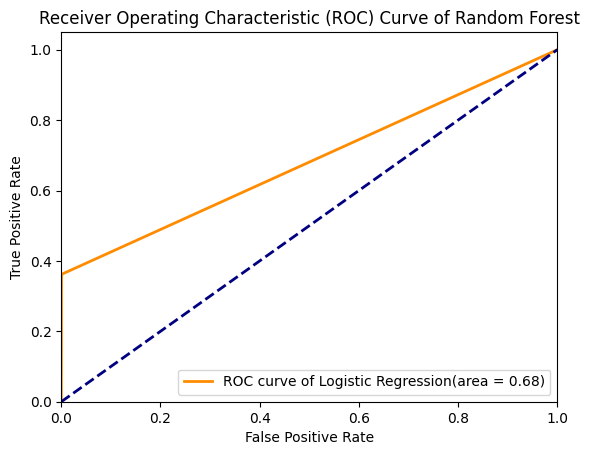

In [51]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve of Logistic Regression(area = {lr_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Random Forest')
plt.legend(loc="lower right")
plt.show()


# KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score , classification_report

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [94]:
y_pred_knn = model_knn.predict(X_test)

# Calculate metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
knn_roc_auc = roc_auc_score(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(knn_roc_auc)

Accuracy: 0.9268
Precision: 0.9082
Recall: 0.9268
0.5608471189962969


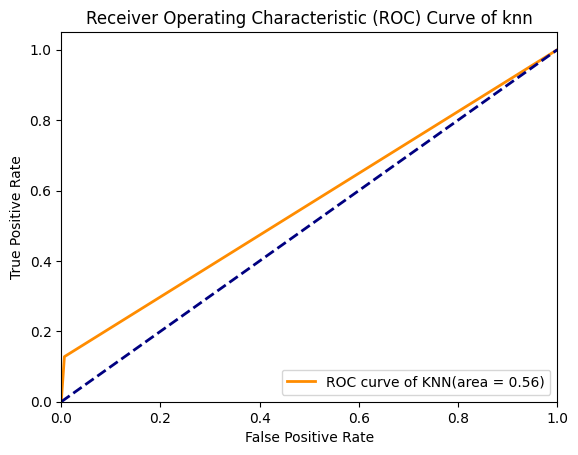

In [95]:
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve of KNN(area = {knn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of knn')
plt.legend(loc="lower right")
plt.show()


# Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [59]:
y_pred_nb = model_nb.predict(X_test)

# Calculate metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
nb_roc_auc = roc_auc_score(y_test, y_pred_nb)

print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(nb_roc_auc)


Accuracy: 0.9500
Precision: 0.9491
Recall: 0.9500
0.6896772669416673


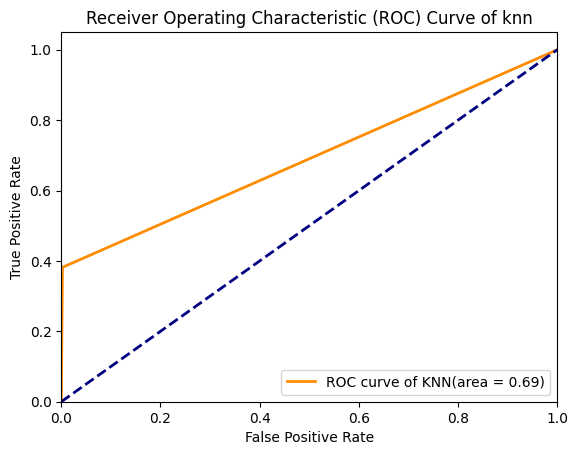

In [60]:
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure()
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve of KNN(area = {nb_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of knn')
plt.legend(loc="lower right")
plt.show()


# Bagging

In [61]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
base_estimator = DecisionTreeClassifier()
model_bagging = BaggingClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)


In [63]:
model_bagging.fit(X_train, y_train)
y_pred_bagging = model_bagging.predict(X_test)


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [66]:
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_bagging = f1_score(y_test, y_pred_bagging, average='weighted')
bagging_roc_auc = roc_auc_score(y_test, y_pred_bagging)

print(f"Accuracy: {accuracy_bagging:.4f}")
print(f"Precision: {precision_bagging:.4f}")
print(f"Recall: {recall_bagging:.4f}")
print(f"F1 Score: {f1_bagging:.4f}")
print(bagging_roc_auc)


Accuracy: 0.9866
Precision: 0.9866
Recall: 0.9866
F1 Score: 0.9861
0.9175282161863999


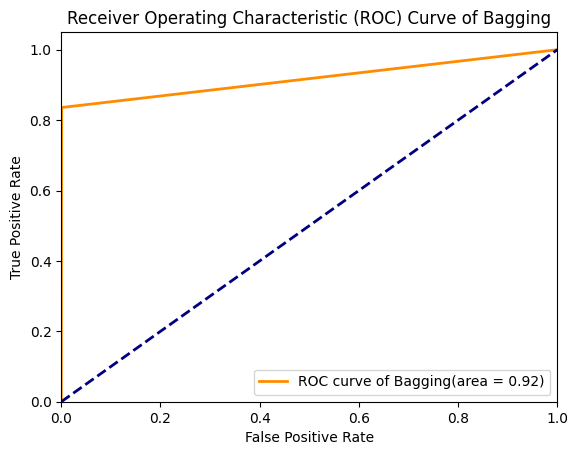

In [67]:
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_pred_bagging)
roc_auc_bagging = auc(fpr_bagging, tpr_bagging)

plt.figure()
plt.plot(fpr_bagging, tpr_bagging, color='darkorange', lw=2, label=f'ROC curve of Bagging(area = {bagging_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Bagging')
plt.legend(loc="lower right")
plt.show()


# Gradient Boosting Machine

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)


In [70]:
model_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
model_gbm.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42)

In [71]:
y_pred_gbm = model_gbm.predict(X_test)


accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
precision_gbm = precision_score(y_test, y_pred_gbm, average='weighted')
recall_gbm = recall_score(y_test, y_pred_gbm, average='weighted')
f1_gbm = f1_score(y_test, y_pred_gbm, average='weighted')
gbm_roc_auc = roc_auc_score(y_test, y_pred_gbm)

print(f"Accuracy: {accuracy_gbm:.4f}")
print(f"Precision: {precision_gbm:.4f}")
print(f"Recall: {recall_gbm:.4f}")
print(f"F1 Score: {f1_gbm:.4f}")
print(gbm_roc_auc)


Accuracy: 0.9834
Precision: 0.9832
Recall: 0.9834
F1 Score: 0.9827
0.9035921439838437


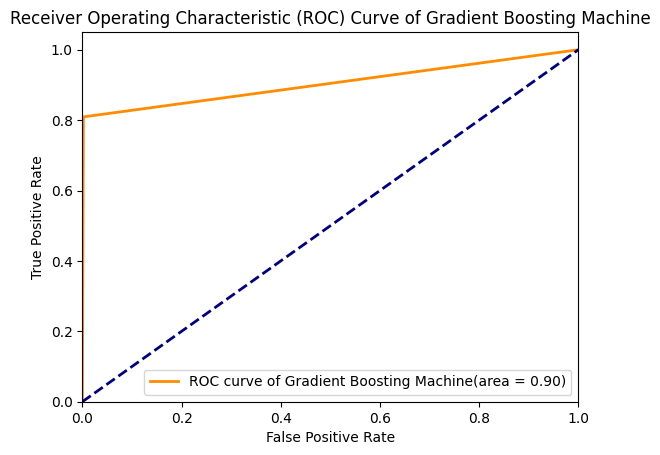

In [73]:
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_gbm)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

plt.figure()
plt.plot(fpr_gbm, tpr_gbm, color='darkorange', lw=2, label=f'ROC curve of Gradient Boosting Machine(area = {gbm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Gradient Boosting Machine')
plt.legend(loc="lower right")
plt.show()


# XGBOOST

In [74]:
from xgboost import XGBClassifier


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)


In [76]:
model_xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [77]:
y_pred_xgb = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(xgb_roc_auc)


Accuracy: 0.9833
Precision: 0.9832
Recall: 0.9833
F1 Score: 0.9826
0.9019254727917461


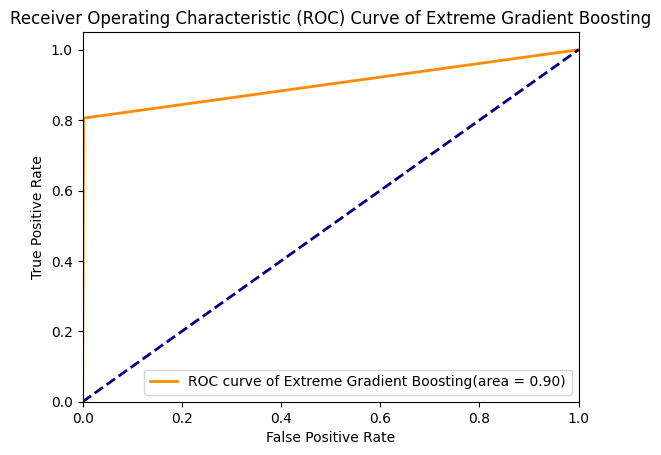

In [78]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve of Extreme Gradient Boosting(area = {xgb_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Extreme Gradient Boosting')
plt.legend(loc="lower right")
plt.show()


# ROC AUC CURVE PLOT

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_pred_probas = {
     'KNN': y_pred_knn,
     'Naive Bayes': y_pred_nb,
     'Decision Tree': y_pred_dt,
     'Logistic Regression': y_pred_lr,
     'Random Forest': y_pred_rf,
     'Bagging': y_pred_bagging,
     'AdaBoost': y_pred_best_adb,
     'Gradient Boosting': y_pred_gbm,
     'XGBoost': y_pred_xgb,
     'LightGBM': y_pred_lgb
 }

for name, y_pred_proba in y_pred_probas.items(): 
    if len(y_test) != len(y_pred_proba): 
        raise ValueError(f"Inconsistent number of samples in {name}: {len(y_test)} in y_test vs {len(y_pred_proba)} in y_pred_proba")

# Plot ROC curves
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('ROC AUC Curves', fontsize=20)

model_names = list(y_pred_probas.keys())
for i, ax in enumerate(axs.flatten()):
    model_name = model_names[i]
    y_pred_proba = y_pred_probas[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(model_name)
    ax.legend(loc="lower right")

# First row title
axs[0, 0].text(-1, 1.2, 'Machine Learning Models', size=15, weight='bold', ha='left')
# Second row title
axs[1, 0].text(-1, 1.2, 'Ensemble Methods', size=15, weight='bold', ha='left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)


In [26]:
models = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Bagging': BaggingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42)
}

y_pred_probas = {}
roc_aucs = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_probas[name] = y_pred_proba
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_aucs[name] = roc_auc
    print(f'{name} ROC AUC: {roc_auc:.2f}')


/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN ROC AUC: 0.63


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Naive Bayes ROC AUC: 0.83
Decision Tree ROC AUC: 0.92


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression ROC AUC: 0.78


/tmp/ipykernel_24/2194986493.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Random Forest ROC AUC: 0.98


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Bagging ROC AUC: 0.98


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost ROC AUC: 0.98


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gradient Boosting ROC AUC: 0.98
XGBoost ROC AUC: 0.99


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 47061, number of negative: 568182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5899
[LightGBM] [Info] Number of data points in the train set: 615243, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076492 -> initscore=-2.490997
[LightGBM] [Info] Start training from score -2.490997
LightGBM ROC AUC: 0.98


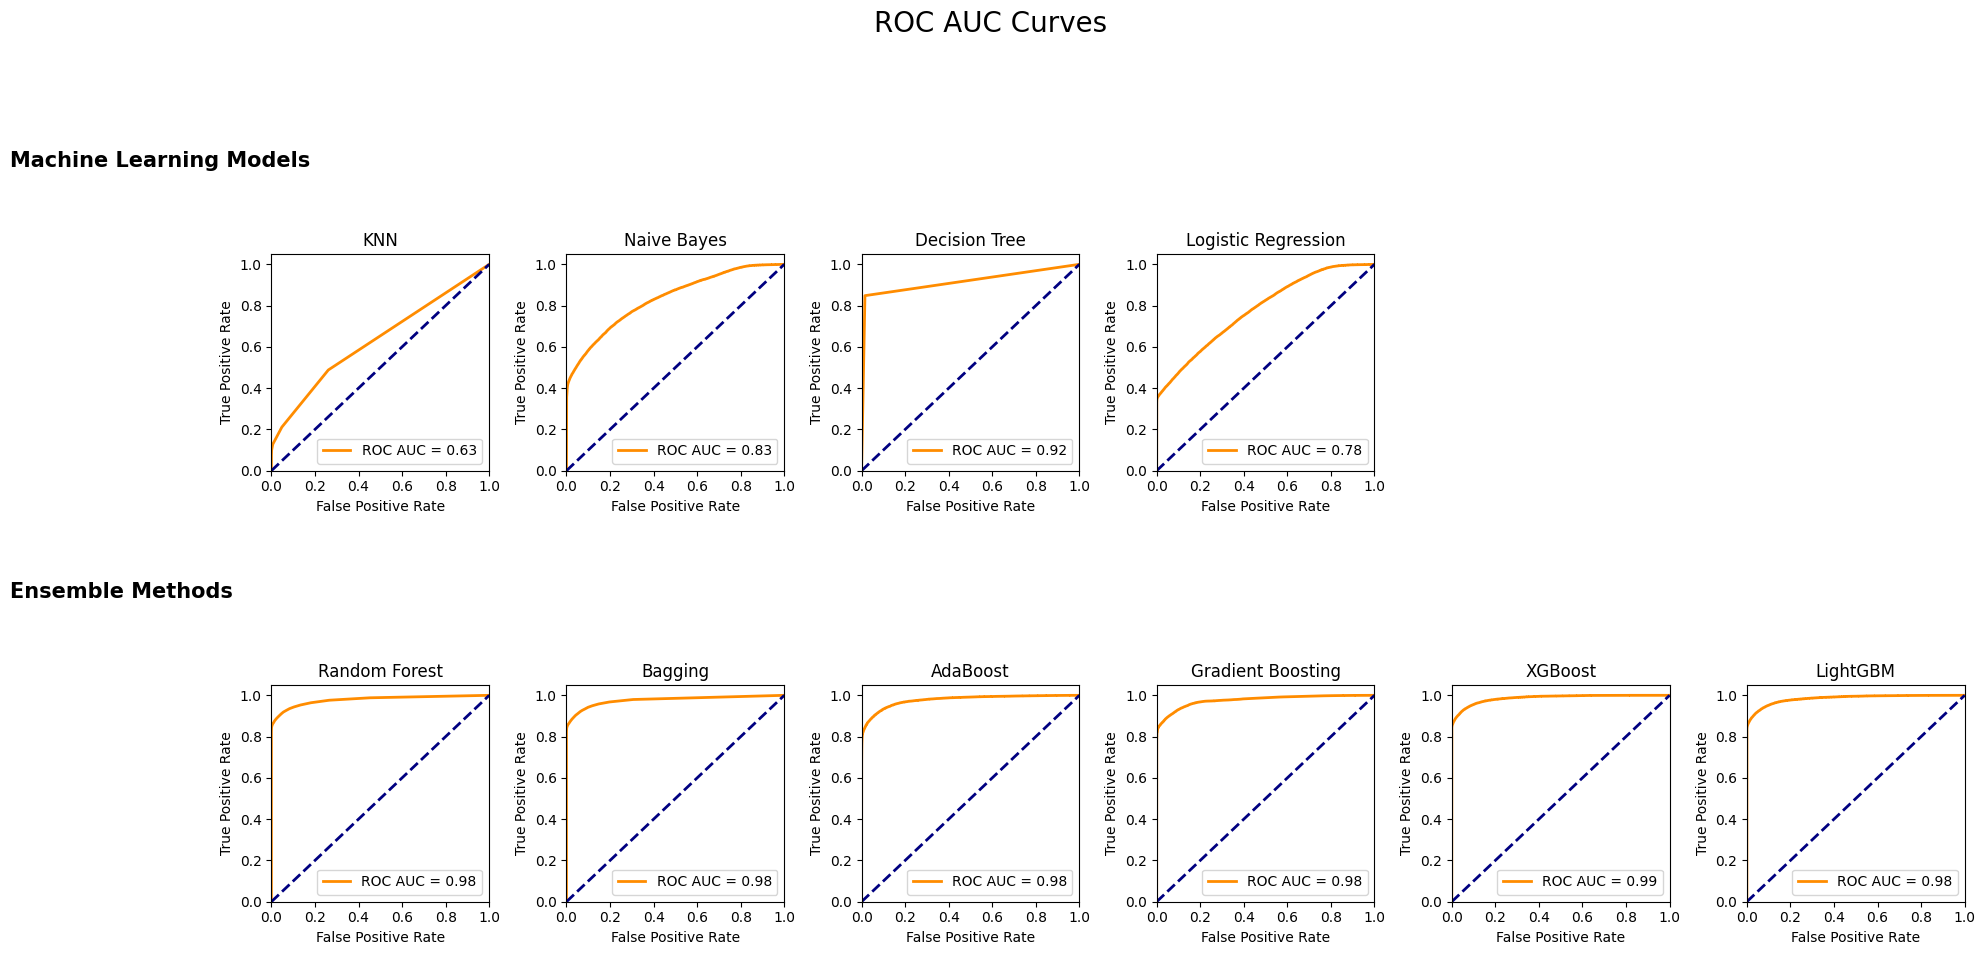

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming models, y_test, and y_pred_probas are defined
fig, axs = plt.subplots(2, 6, figsize=(20, 10))  # Adjusted for 6 subplots in the second row
fig.suptitle('ROC AUC Curves', fontsize=20)

model_names = list(models.keys())
first_row_models = model_names[:4]  # First 4 models
second_row_models = model_names[4:]  # Remaining models, including Random Forest

# Plot for the first row (4 models)
for i, model_name in enumerate(first_row_models):
    ax = axs[0, i]
    y_pred_proba = y_pred_probas[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(model_name)
    ax.legend(loc="lower right")

# Disable empty axes in the first row
for i in range(4, 6):
    axs[0, i].axis('off')

# Plot for the second row (6 models)
for i, model_name in enumerate(second_row_models):
    ax = axs[1, i]
    y_pred_proba = y_pred_probas[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(model_name)
    ax.legend(loc="lower right")

# Adding titles for rows
axs[0, 0].annotate("Machine Learning Models", xy=(-1.2, 1.4), xycoords="axes fraction", fontsize=15, weight='bold', ha='left')
axs[1, 0].annotate("Ensemble Methods", xy=(-1.2, 1.4), xycoords="axes fraction", fontsize=15, weight='bold', ha='left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('revised_roc_auc_curves.png')
plt.show()


# Stacked Generalization

In [24]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)


In [26]:
import joblib

In [26]:
base_learners = [
    ('knn', KNeighborsClassifier()),
    ('naive_bayes', GaussianNB()),
    ('decision_tree', DecisionTreeClassifier()),
    ('logistic_regression', LogisticRegression(max_iter=200)),
    ('random_forest', RandomForestClassifier(n_estimators=100)),
    ('adaboost', AdaBoostClassifier(n_estimators=100)),
    ('xgboost', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('lightgbm', LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]


In [27]:
final_estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=final_estimator, passthrough=True)

stacking_clf.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

[LightGBM] [Info] Number of positive: 47061, number of negative: 568182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5899
[LightGBM] [Info] Number of data points in the train set: 615243, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076492 -> initscore=-2.490997
[LightGBM] [Info] Start training from score -2.490997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[LightGBM] [Info] Number of positive: 37649, number of negative: 454545
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5901
[LightGBM] [Info] Number of data points in the train set: 492194, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076492 -> initscore=-2.490991
[LightGBM] [Info] Start training from score -2.490991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

StackingClassifier(estimators=[('knn', KNeighborsClassifier()),
                               ('naive_bayes', GaussianNB()),
                               ('decision_tree', DecisionTreeClassifier()),
                               ('logistic_regression',
                                LogisticRegression(max_iter=200)),
                               ('random_forest', RandomForestClassifier()),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=No...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=3, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...),
                   passthrough=True)

In [27]:
stacking_clf = joblib.load('/kaggle/input/stacked_model/scikitlearn/default/1/stacked_model.pkl')

In [28]:
y_pred_stacked = stacking_clf.predict(X_test)


accuracy_stacked = accuracy_score(y_test, y_pred_stacked)
precision_stacked = precision_score(y_test, y_pred_stacked, average='weighted')
recall_stacked = recall_score(y_test, y_pred_stacked, average='weighted')
f1_stacked = f1_score(y_test, y_pred_stacked, average='weighted')

print(f"Accuracy: {accuracy_stacked:.4f}")
print(f"Precision: {precision_stacked:.4f}")
print(f"Recall: {recall_stacked:.4f}")
print(f"F1 Score: {f1_stacked:.4f}")




Accuracy: 0.9872
Precision: 0.9873
Recall: 0.9872
F1 Score: 0.9867


In [29]:
import shap

In [ ]:

explainer_stacked = shap.KernelExplainer(stacking_clf.predict, X_train, link="logit")

# Calculate SHAP values for the test set
shap_values_stacked = explainer_stacked.shap_values(X_test, nsamples=100)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer_stacked.expected_value, shap_values_stacked[0 ], X_test[0])

# Summary plot
shap.summary_plot(shap_values_stacked, X_test)


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


  0%|          | 0/263676 [00:00<?, ?it/s]

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
